## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp

/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
import pickle
pickle_in = open("pickled_0.076_gamma","rb")
syn = pickle.load(pickle_in)

In [6]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [7]:
times, counts = getLineage("DoupeAggregate.tsv")

In [8]:
from mpmath import *
import cmath

import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [9]:
def F(x, y, t, r, gamma):
#     v = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5)
    v = (1 - 4 * r)** 0.5    
#     w = (gamma * (1 - 2 * r) - 2 * r) / scipy.linalg.fractional_matrix_power(
#         2 * gamma * (1 - 4 * r), 0.5)
    w = (gamma * (1 - 2 * r) - 2 * r) / (2 * gamma * (1 - 4 * r)** 0.5)    
#     gg = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5) / gamma
    gg = (1 - 4 * r)** 0.5 / gamma
    u = (1 - y) * np.exp(-gamma * t)
    u0 = (1 - y)
    Q = 1 + 2 * w - gg * u0 + (2 * r * (x - y) + y - 1) / gamma
    C = (-Q * whitm(w, 0, gg * u0) + (1 + 2 * w) * whitm(1 + w, 0, gg * u0)) / \
        (Q * whitw(w, 0, gg * u0) + 2 * whitw(1 + w, 0, gg * u0))
    f = 1 - u + \
        (u * (1 + v) - gamma * (1 + 2 * w)) / (2 * r) + \
        (gamma / (2 * r)) * ((1 + 2 * w) * whitm(1 + w, 0, u * gg) -
                             2 * C * whitw(1 + w, 0, u * gg)) / \
        (whitm(w, 0, u * gg) + C * whitw(w, 0, u * gg))
    return f


def Antal(z, t, r, gamma):
    g = []
    for k in range(len(z)):
        if z[k] == 1:
            g.append(1)
        else:
            g.append(F(z[k], z[k], t, r, gamma))
            
#     for k in range(1, len(z) + 1):
#         if z[k] == 1:
#             g[k] = 1
#         else:
#             g[k] = F(z[k], z[k], t, r, gamma)

    return g

In [10]:
def Psurv(t, l, r, rho):
    rho = rho - 0.00001
    gamma = rho / (1 - rho)
    T = l * t
    p = 1 - np.real(Antal([0], T, r, gamma))
#     if (p <= 0 or p > 1 or np.isnan(p)):
    if (p <= 0 or p > 1):
        p = Psurv(t, l, r + 0.00001, rho - 0.001)
    return p

In [11]:
def Pn(n, t, l, r, rho, N, returnConsecutive='', max_n=''):
    if max(n) >= N:
        N = max(n) + 1
    rho = rho - 0.00001
    assert (rho < 1)
    assert (rho > 0)
    gamma = rho / (1 - rho)
    T = l * t
#     k = range(N)
#     Gvals = Antal(cmath.exp(2 * np.pi * 1j * k / N), T, r, gamma)
    Gvals = Antal([cmath.exp(2 * np.pi * 1j * k / N) for k in range(int(N))], T, r, gamma)
    p = []

    if returnConsecutive:
        p = np.zeros(max_n)
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#              p[n[lp]] = \
#                 np.real((1 / N) *
#                         sum(Gvals * np.exp(-2 * np.pi * 1j * k * n[lp] / N)))
            temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[n[lp]-1] = np.real((1 / N) *sum([a*b for a,b in zip(Gvals,temporary)]))
                               
    else:
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#             p[lp] = \
#                 np.real((1 / N) * sum(Gvals *
#                                       np.exp(-2 * np.pi * 1j * k * n[lp] / N)))          
            Temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[lp] = np.real((1 / N) * sum(a*b for a,b in zip(Gvals,Temporary)))
#     print(Gvals)
    tst = sum(p)
    print(tst)
    if (tst > 1 or tst < 0 or np.isnan(tst)):
        print('Pathological point: r=' + str(r) + ' rho=' + str(
            rho) + '. Making 0.1% perturbation')
        p = Pn(n, t, l, r + 0.00001, rho - 0.001, N, returnConsecutive, max_n)

#     for x in range(len(p)):
#         if (p[x] < 0):
#             p[x] = 0

#     p[p < 0 & p > -1e-5] = 0

    return(p)

In [12]:
def logLikelihood(obs,lpBins,binSize):
    maxClone = len(lpBins)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    obsBins = [sum(obs[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    return(sum([obsBins[j]*lpBins[j] for j in range(maxClone)]))

def allLogLike(obs,lpBins,binSize):
    return(sum([logLikelihood(o,p,binSize) for o,p in zip(obs,lpBins)]))

def logProbability(probability,binSize):
    binSizeList = [[sum(t[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))] for t in probability]
    logFreq = [[0 if n<=0 else math.log10(n) for n in t] for t in binSizeList]
    return(logFreq)

def calculateLikelihood(probability,binSize,data):
    lpBins = logProbability(probability, binSize)
    like = allLogLike(data,lpBins,binSize)
    #print(like)
    return(like)

In [13]:
def main(t,nRange,lambdaRange,rhoRange,rRange,binSize,data):
    maxN = max(list(map(max, nRange)))
    
#     PScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                        len(nRange), maxN)    
    PScanPP = [[[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]
    
#     PSurvScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                            len(nRange))    
    PSurvScanPP = [[[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]

    timePoints = range(len(t))
    nBadValues = 0

    for L1 in range(len(lambdaRange)):       
        PScanPP_local = [[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]
             
        PSurvScanPP_local = [[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]

        for L2 in range(len(rhoRange)):
            for L3 in range(len(rRange)):
                for L4 in timePoints:
                    probS = Psurv(t[L4], lambdaRange[L1], rRange[L3], rhoRange[L2])
                    avgN = 1 / probS
                    Niter = max([normal_round(int(4*avgN)), normal_round(1.5*max(nRange[L4])), 10])
                    probN = Pn(nRange[L4], t[L4], lambdaRange[L1], rRange[L3],
                               rhoRange[L2], Niter, 'returnConsecutive', maxN)

                    if any(probN > 1) or \
                            sum(probN) > 1 or \
                            probS > 1 or \
                            probS <0 or \
                            abs(probS-sum(probN))>1e-3:
                        print('Bad values at time t=' + str(t[L4]) + ' lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
                        print('any(probN>1=' + str(any(probN>1)) + ', sum(probN)>1=' + str(sum(probN)>1) + ', (probS-sum(probN))=' + str(probS-sum(probN)))
                        nBadValues += 1
                    else:
                        print('Completed time t=' + str(t[L4]) + ' weeks, lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
    
#                     PSurvScanPP_local[L2][L3][L4] = probS
                    PScanPP_local[L2][L3][L4][:] = probN/probS
                PScanPP_local[L2][L3] = calculateLikelihood(PScanPP_local[L2][L3],binSize,data)
        PSurvScanPP[L1] = PSurvScanPP_local
        PScanPP[L1] = PScanPP_local

    return(PScanPP) 

In [14]:
nSize = len(np.transpose(syn))
nBin = int(round(np.log(nSize)/np.log(2)+0.5))
binSize = np.append([1],[2**(n-1) for n in range(1,(nBin+1))])


In [15]:
times

array([  3.,  10.,  21.,  42.,  84., 180., 365.])

In [16]:
t = times/7
nRange = [list(range(1, max(np.where(t>0)[0])+1)) for t in syn]
lambdaRange = [2.9]
bins=15
rhoRange = [(i*0.8/bins) for i in range(1,bins)]
rRange = [(i*0.2/bins) for i in range(1,bins)]


In [19]:
%time result = main(t,nRange,lambdaRange,rhoRange,rRange,binSize,syn)

0.8793530424406881
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.05333333333333334 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12062738886244095')]
0.9890951158903005
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.05333333333333334 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010483575165402437')]
0.9889411472186259
Bad values at time t=3.0 lambda=2.9 rho=0.05333333333333334 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087728039911846301')]
0.9729979973855208
Bad values at time t=6.0 lambda=2.9 rho=0.05333333333333334 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01686752927414259')]
0.9383302729823612
Bad values at time t=12.0 lambda=2.9 rho=0.05333333333333334 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017747891449960584')]
0.7892974620670906


0.9612542280737745
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.05333333333333334 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.035851253538022543')]
0.9335955130576216
Bad values at time t=3.0 lambda=2.9 rho=0.05333333333333334 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.051287528945534899')]
0.8634956380911751
Bad values at time t=6.0 lambda=2.9 rho=0.05333333333333334 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075398379347739519')]
0.7259586910363375
Bad values at time t=12.0 lambda=2.9 rho=0.05333333333333334 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.064051875602073038')]
0.39631113859733125
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.05333333333333334 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030840442947199564')]
0.11936771981825892
Bad

0.943594685375432
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.05333333333333334 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.051127298973100643')]
0.9046757949235112
Bad values at time t=3.0 lambda=2.9 rho=0.05333333333333334 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.068704757328060917')]
0.8242455534310874
Bad values at time t=6.0 lambda=2.9 rho=0.05333333333333334 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075692280494286224')]
0.6475062061193954
Bad values at time t=12.0 lambda=2.9 rho=0.05333333333333334 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052226787679551356')]
0.3012513981902798
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.05333333333333334 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023622490767894355')]
0.07587446679564974
Bad v

0.9358217566276732
Bad values at time t=3.0 lambda=2.9 rho=0.10666666666666667 r=0.06666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022682087966770403')]
0.8125614508192556
Bad values at time t=6.0 lambda=2.9 rho=0.10666666666666667 r=0.06666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033352327574176499')]
0.5434560949930991
Bad values at time t=12.0 lambda=2.9 rho=0.10666666666666667 r=0.06666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029908484626718801')]
0.23642459578055844
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.10666666666666667 r=0.06666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012423638975275181')]
0.09975495505058873
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.10666666666666667 r=0.06666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010033336939942461')]
0.8865104194267588
Bad

0.872338303966292
Bad values at time t=3.0 lambda=2.9 rho=0.10666666666666667 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045815573438768853')]
0.6848264201794518
Bad values at time t=6.0 lambda=2.9 rho=0.10666666666666667 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052284623354013959')]
0.3764025659349895
Bad values at time t=12.0 lambda=2.9 rho=0.10666666666666667 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037233075876254407')]
0.12406076525233227
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.10666666666666667 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016385783645919874')]
0.04507352479745432
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.10666666666666667 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.009608985347207534')]
0.883536063454699
Bad v

0.29399161162025794
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16000000000000003 r=0.04000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011483135471574424')]
0.15322236201219866
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16000000000000003 r=0.04000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017226335254114378')]
0.8958219454037575
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.16000000000000003 r=0.05333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10336849060380904')]
0.9730371191841589
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16000000000000003 r=0.05333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011797273495490979')]
0.9205776821979748
Bad values at time t=3.0 lambda=2.9 rho=0.16000000000000003 r=0.05333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087214781603

0.11630273747422043
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16000000000000003 r=0.12000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098672763559162768')]
0.05131402894522895
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16000000000000003 r=0.12000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.007087916537441577')]
0.8908769213334788
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.16000000000000003 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10711455409114068')]
0.93693425191111
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16000000000000003 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027273347470453957')]
0.8212434775115659
Bad values at time t=3.0 lambda=2.9 rho=0.16000000000000003 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0289010760281135

0.9826201715421544
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036472297211883609')]
0.9374155442306469
Bad values at time t=3.0 lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010044070364374491')]
0.8068521118350813
Completed time t=6.0 weeks, lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
0.5928794420989237
Completed time t=12.0 weeks, lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
0.3641628820345931
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
0.20872777332361392
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.21333333333333335 r=0.02666666666666667
0.9054698964063781
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.21333333333333335 r=0.04000000000000001
any(probN>1=False, sum(probN)>1=False, (

0.2621252945478469
Bad values at time t=12.0 lambda=2.9 rho=0.21333333333333335 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013353634344302201')]
0.12212567726790632
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.21333333333333335 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049640477158084118')]
0.05791791132546332
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.21333333333333335 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044118721383312673')]
0.8980034050382395
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.21333333333333335 r=0.12000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.098546388270778884')]
0.9249968816539451
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.21333333333333335 r=0.12000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01866012217

0.16446140647866475
Bad values at time t=12.0 lambda=2.9 rho=0.21333333333333335 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019155638533639607')]
0.06972864586657497
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.21333333333333335 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080314909480769109')]
0.03145543595759002
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.21333333333333335 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053543005807880281')]
0.9178752292770137
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.26666666666666666 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.081469772001581231')]
0.988281559348103
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.26666666666666666 r=0.013333333333333334
0.9545126470025548
Completed time t=3.0 weeks, lambda=2.9 rho=0.26666666

0.1344834109556792
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.26666666666666666 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019348071844462467')]
0.06680989362386189
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.26666666666666666 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002233082436157191')]
0.905519702747474
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.26666666666666666 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.089324811974214491')]
0.9114945585858312
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.26666666666666666 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011848082532600612')]
0.7302100689859231
Bad values at time t=3.0 lambda=2.9 rho=0.26666666666666666 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.008378115190188

0.0735034954713696
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.26666666666666666 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0054423412663052589')]
0.03441135350352237
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.26666666666666666 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0041218057622872117')]
0.8955736416935196
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.26666666666666666 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.095527181153778118')]
0.8551194901058286
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.26666666666666666 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02239400695948679')]
0.6108669257728722
Bad values at time t=3.0 lambda=2.9 rho=0.26666666666666666 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01971513251906

0.7062974108667865
Bad values at time t=3.0 lambda=2.9 rho=0.32000000000000006 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036531668694332886')]
0.45510500358362543
Bad values at time t=6.0 lambda=2.9 rho=0.32000000000000006 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040452819495389591')]
0.2597257513553152
Bad values at time t=12.0 lambda=2.9 rho=0.32000000000000006 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034513102759011205')]
0.13219635289658221
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.32000000000000006 r=0.09333333333333334
0.06692326658893057
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32000000000000006 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012660470594059031')]
0.9112415845123101
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.32000000000000006 r=0.106

0.5665200884537147
Bad values at time t=3.0 lambda=2.9 rho=0.32000000000000006 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012421457162085314')]
0.30593637130753937
Bad values at time t=6.0 lambda=2.9 rho=0.32000000000000006 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013009202848074497')]
0.15278985359202327
Bad values at time t=12.0 lambda=2.9 rho=0.32000000000000006 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0099343358333140175')]
0.07293925134436648
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32000000000000006 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037533005652331947')]
0.0348509359858666
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32000000000000006 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003137445877331925')]
0.898152542257898
B

0.8741604261033294
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.37333333333333335 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0045589787154368677')]
0.6673386223897416
Bad values at time t=3.0 lambda=2.9 rho=0.37333333333333335 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0020205633391564559')]
0.4339091051042213
Bad values at time t=6.0 lambda=2.9 rho=0.37333333333333335 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021867962380718309')]
0.2534226462806013
Bad values at time t=12.0 lambda=2.9 rho=0.37333333333333335 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018838759064319088')]
0.13064018661410462
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.37333333333333335 r=0.09333333333333334
0.06694172243538754
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.37333333333333335 r=0.09

0.5202529255638018
Bad values at time t=3.0 lambda=2.9 rho=0.37333333333333335 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085013069019448384')]
0.2878206579332303
Bad values at time t=6.0 lambda=2.9 rho=0.37333333333333335 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0090813053925270504')]
0.1494756164006051
Bad values at time t=12.0 lambda=2.9 rho=0.37333333333333335 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071775384542657472')]
0.07275570424826068
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.37333333333333335 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025611339567020303')]
0.03528323343692855
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.37333333333333335 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023645263993582119')]
0.899462263997265

0.6381156139334281
Bad values at time t=3.0 lambda=2.9 rho=0.4266666666666667 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011017217994111483')]
0.42017505808167166
Bad values at time t=6.0 lambda=2.9 rho=0.4266666666666667 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011735990345529412')]
0.24914714896466167
Bad values at time t=12.0 lambda=2.9 rho=0.4266666666666667 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010205958074403498')]
0.1295055315961359
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4266666666666667 r=0.09333333333333334
0.06689200764990592
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4266666666666667 r=0.09333333333333334
0.9201920178617407
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4266666666666667 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.06340790850

0.07267822404092432
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4266666666666667 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017313765190433844')]
0.035653708733627484
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4266666666666667 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017659961507894423')]
0.8992368574602246
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4266666666666667 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.072771498191170347')]
0.7381203130880155
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4266666666666667 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0099717842209184893')]
0.4683293747536315
Bad values at time t=3.0 lambda=2.9 rho=0.4266666666666667 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006751405603496

0.8051178308100229
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002470487500049634')]
0.5849025937626142
Completed time t=3.0 weeks, lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
0.3785701783260897
Bad values at time t=6.0 lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010392508436681269')]
0.22177243785987683
Completed time t=12.0 weeks, lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
0.11431858405994587
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
0.05877901127272892
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.48000000000000004 r=0.10666666666666667
0.9185054262745654
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.48000000000000004 r=0.12000000000000001
any(probN>1=False, sum(probN)>1=False, 

0.067486208349666
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.48000000000000004 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013946883943655314')]
0.033218287059454
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.48000000000000004 r=0.18666666666666668
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014744463596915794')]
0.9641008250349723
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.5333333333333333 r=0.013333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032056880388527054')]
0.9660385761607836
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5333333333333333 r=0.013333333333333334
0.9129753397365394
Completed time t=3.0 weeks, lambda=2.9 rho=0.5333333333333333 r=0.013333333333333334
0.8255500779861837
Completed time t=6.0 weeks, lambda=2.9 rho=0.5333333333333333 r=0.013333333333333334
0.6928501417277145
Completed time t=12.0 weeks, lambda=2.9 r

0.10233509436261669
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5333333333333333 r=0.12000000000000001
0.052424601592658306
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5333333333333333 r=0.12000000000000001
0.9135438168077661
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.5333333333333333 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.050017965614995497')]
0.7415990681930342
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.5333333333333333 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002625658217760396')]
0.5134574679825417
Bad values at time t=3.0 lambda=2.9 rho=0.5333333333333333 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011523862712425892')]
0.3209043616956104
Bad values at time t=6.0 lambda=2.9 rho=0.5333333333333333 r=0.13333333333333333
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0

0.7698187469937915
Completed time t=3.0 weeks, lambda=2.9 rho=0.5866666666666667 r=0.04000000000000001
0.6071633197999139
Completed time t=6.0 weeks, lambda=2.9 rho=0.5866666666666667 r=0.04000000000000001
0.42680277587800647
Completed time t=12.0 weeks, lambda=2.9 rho=0.5866666666666667 r=0.04000000000000001
0.25420336778087615
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5866666666666667 r=0.04000000000000001
0.14286583771227285
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5866666666666667 r=0.04000000000000001
0.9503190722295347
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.5866666666666667 r=0.05333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030116857773611727')]
0.8648655825365521
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.5866666666666667 r=0.05333333333333334
0.7150965753724033
Completed time t=3.0 weeks, lambda=2.9 rho=0.5866666666666667 r=0.05333333333333334
0.5369386891192162
Complet

0.45558811548248745
Bad values at time t=3.0 lambda=2.9 rho=0.5866666666666667 r=0.16000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013206792635578335')]
0.2776874679983215
Bad values at time t=6.0 lambda=2.9 rho=0.5866666666666667 r=0.16000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015946198255895605')]
0.15565783312304127
Bad values at time t=12.0 lambda=2.9 rho=0.5866666666666667 r=0.16000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014610057475535898')]
0.07818562343695708
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.5866666666666667 r=0.16000000000000003
0.03944313027985982
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.5866666666666667 r=0.16000000000000003
0.8926412286380364
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.5866666666666667 r=0.17333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0474852711

0.1451608814290582
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6400000000000001 r=0.08000000000000002
0.07679170338014142
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6400000000000001 r=0.08000000000000002
0.9290415758992794
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028588809362081191')]
0.7706848341647773
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
0.5806531332963312
Completed time t=3.0 weeks, lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
0.3945518187771485
Completed time t=6.0 weeks, lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
0.24042118151399458
Completed time t=12.0 weeks, lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
0.12705594802715817
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6400000000000001 r=0.09333333333333334
0.066529307

0.9039109285009231
Completed time t=3.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.013333333333333334
0.818127282646276
Completed time t=6.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.013333333333333334
0.6876142884797102
Completed time t=12.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.013333333333333334
0.503882564154137
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6933333333333334 r=0.013333333333333334
0.3326133174669817
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6933333333333334 r=0.013333333333333334
0.9718948021430787
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.6933333333333334 r=0.02666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012485042138512314')]
0.9165538470277397
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6933333333333334 r=0.02666666666666667
0.8247038495394984
Completed time t=3.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.02666666666666667
0.692254009932551
Complete

0.047341234532288404
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6933333333333334 r=0.13333333333333333
0.8916014415406911
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02904484415684172')]
0.6665025584072519
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.46119081688381985
Completed time t=3.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.29000337300804735
Completed time t=6.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.166342873383259
Completed time t=12.0 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.08444888006502246
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.043144678790956036
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6933333333333334 r=0.14666666666666667
0.8833157

0.09054470316232464
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7466666666666667 r=0.06666666666666667
0.9314263448165246
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014158895013356987')]
0.7767802498692278
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.6053837180929333
Completed time t=3.0 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.42591876823789876
Completed time t=6.0 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.267385447607296
Completed time t=12.0 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.14447613665472905
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.07660814183537615
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.7466666666666667 r=0.08000000000000002
0.921328765

In [20]:
np.shape(result)

(1, 14, 14)

In [ ]:
result[0]

In [21]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.004,0.2,0.016,0.8],aspect=0.25)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    plt.colorbar()
    plt.show()

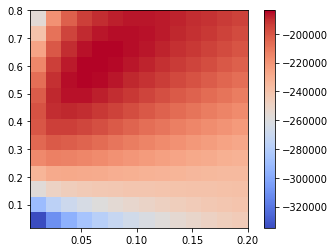

In [22]:
plotLikelihood(result[0])

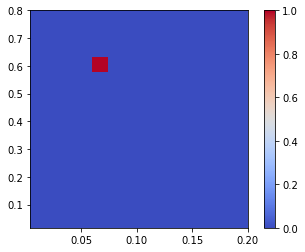

In [23]:
scaledR = result[0]-max(max(i) for i in result[0])
expR = 10**(scaledR)
plotLikelihood(expR)

In [24]:
allSum = sum([sum(r) for r in expR])
rhoNormalised = [sum(rho) for rho in expR]/allSum
rNormalised = [sum(rho) for rho in np.transpose(expR)]/allSum
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)
(array([0, 1, 2, 3]),)


In [26]:
rRange[4]

0.06666666666666667

In [27]:
rhoDistribution = np.cumsum(rhoNormalised)
print(np.where(rhoDistribution>0.025))
print(np.where(rhoDistribution<0.975))

(array([10, 11, 12, 13]),)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)


In [28]:
rhoRange[10]

0.5866666666666667

In [33]:
rRange[4]/rhoRange[10]

0.11363636363636363

In [ ]:
pickle_out = open("pickled_grid_px20","wb")
pickle.dump(expR, pickle_out)
pickle_out.close()

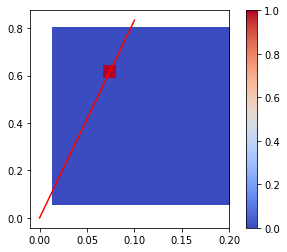

In [30]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.2/15,0.2,0.8/15,0.8],aspect=0.25)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    x = np.linspace(0,0.1,50)
    y = x/0.12
    plt.plot(x, y, '-r', label='y=2x+1')
    plt.colorbar()
    plt.show()

plotLikelihood(expR)

In [31]:
max([max(r) for r in expR])

1.0

In [32]:
np.where(expR == 1)

(array([10]), array([4]))

In [ ]:
allSum = sum([sum(r) for r in expR])
rhoNormalised = [sum(rho) for rho in expR]/allSum
rNormalised = [sum(rho) for rho in np.transpose(expR)]/allSum
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

In [ ]:
rRange[7:12]

In [ ]:
rhoDistribution = np.cumsum(rhoNormalised)
print(np.where(rhoDistribution>0.025))
print(np.where(rhoDistribution<0.975))

In [ ]:
rhoRange[37:42]